In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:41 - loss: 0.3407 - STD: 8.6251e-05 - MAE: 0.5749

 4/64 [>.............................] - ETA: 1s - loss: 0.1363 - STD: 3.8465e-04 - MAE: 0.3065  

 5/64 [=>............................] - ETA: 2s - loss: 0.1113 - STD: 3.4717e-04 - MAE: 0.2606

 6/64 [=>............................] - ETA: 2s - loss: 0.0954 - STD: 3.0721e-04 - MAE: 0.2326

 7/64 [==>...........................] - ETA: 2s - loss: 0.0847 - STD: 2.7198e-04 - MAE: 0.2149

 8/64 [==>...........................] - ETA: 2s - loss: 0.0771 - STD: 2.4248e-04 - MAE: 0.2031

 9/64 [===>..........................] - ETA: 2s - loss: 0.0714 - STD: 2.1796e-04 - MAE: 0.1949

10/64 [===>..........................] - ETA: 2s - loss: 0.0671 - STD: 1.9751e-04 - MAE: 0.1889

11/64 [====>.........................] - ETA: 2s - loss: 0.0636 - STD: 1.8032e-04 - MAE: 0.1842

12/64 [====>.........................] - ETA: 2s - loss: 0.0606 - STD: 1.6571e-04 - MAE: 0.1804

13/64 [=====>........................] - ETA: 2s - loss: 0.0583 - STD: 1.5319e-04 - MAE: 0.1774

14/64 [=====>........................] - ETA: 2s - loss: 0.0563 - STD: 1.4238e-04 - MAE: 0.1750

15/64 [======>.......................] - ETA: 2s - loss: 0.0545 - STD: 1.3302e-04 - MAE: 0.1728

16/64 [======>.......................] - ETA: 2s - loss: 0.0530 - STD: 1.2487e-04 - MAE: 0.1708

17/64 [======>.......................] - ETA: 2s - loss: 0.0515 - STD: 1.1774e-04 - MAE: 0.1689

18/64 [=======>......................] - ETA: 2s - loss: 0.0503 - STD: 1.1146e-04 - MAE: 0.1671

19/64 [=======>......................] - ETA: 2s - loss: 0.0491 - STD: 1.0589e-04 - MAE: 0.1655

20/64 [========>.....................] - ETA: 2s - loss: 0.0480 - STD: 1.0093e-04 - MAE: 0.1639

21/64 [========>.....................] - ETA: 2s - loss: 0.0470 - STD: 9.6497e-05 - MAE: 0.1623

22/64 [=========>....................] - ETA: 2s - loss: 0.0460 - STD: 9.2533e-05 - MAE: 0.1606

23/64 [=========>....................] - ETA: 2s - loss: 0.0450 - STD: 8.8959e-05 - MAE: 0.1589

24/64 [==========>...................] - ETA: 2s - loss: 0.0441 - STD: 8.5729e-05 - MAE: 0.1571

25/64 [==========>...................] - ETA: 2s - loss: 0.0431 - STD: 8.2800e-05 - MAE: 0.1551

26/64 [===========>..................] - ETA: 2s - loss: 0.0422 - STD: 8.0133e-05 - MAE: 0.1531

27/64 [===========>..................] - ETA: 2s - loss: 0.0413 - STD: 7.7678e-05 - MAE: 0.1511

28/64 [============>.................] - ETA: 2s - loss: 0.0404 - STD: 7.5425e-05 - MAE: 0.1489

29/64 [============>.................] - ETA: 2s - loss: 0.0395 - STD: 7.3342e-05 - MAE: 0.1467

30/64 [=============>................] - ETA: 2s - loss: 0.0386 - STD: 7.1420e-05 - MAE: 0.1445

31/64 [=============>................] - ETA: 2s - loss: 0.0377 - STD: 6.9641e-05 - MAE: 0.1424

32/64 [==============>...............] - ETA: 2s - loss: 0.0369 - STD: 6.7997e-05 - MAE: 0.1403

33/64 [==============>...............] - ETA: 1s - loss: 0.0361 - STD: 6.6462e-05 - MAE: 0.1384

34/64 [==============>...............] - ETA: 1s - loss: 0.0353 - STD: 6.5034e-05 - MAE: 0.1366

35/64 [===============>..............] - ETA: 1s - loss: 0.0346 - STD: 6.3689e-05 - MAE: 0.1350

36/64 [===============>..............] - ETA: 1s - loss: 0.0339 - STD: 6.2418e-05 - MAE: 0.1336

37/64 [================>.............] - ETA: 1s - loss: 0.0333 - STD: 6.1205e-05 - MAE: 0.1324

38/64 [================>.............] - ETA: 1s - loss: 0.0327 - STD: 6.0046e-05 - MAE: 0.1313

39/64 [=================>............] - ETA: 1s - loss: 0.0322 - STD: 5.8929e-05 - MAE: 0.1303

40/64 [=================>............] - ETA: 1s - loss: 0.0317 - STD: 5.7840e-05 - MAE: 0.1293

41/64 [==================>...........] - ETA: 1s - loss: 0.0312 - STD: 5.6783e-05 - MAE: 0.1285

42/64 [==================>...........] - ETA: 1s - loss: 0.0307 - STD: 5.5741e-05 - MAE: 0.1275

43/64 [===================>..........] - ETA: 1s - loss: 0.0303 - STD: 5.4723e-05 - MAE: 0.1266

44/64 [===================>..........] - ETA: 1s - loss: 0.0298 - STD: 5.3728e-05 - MAE: 0.1257

45/64 [====================>.........] - ETA: 1s - loss: 0.0294 - STD: 5.2755e-05 - MAE: 0.1247

46/64 [====================>.........] - ETA: 1s - loss: 0.0290 - STD: 5.1810e-05 - MAE: 0.1238

47/64 [=====================>........] - ETA: 1s - loss: 0.0286 - STD: 5.0891e-05 - MAE: 0.1229

48/64 [=====================>........] - ETA: 1s - loss: 0.0282 - STD: 4.9998e-05 - MAE: 0.1219

49/64 [=====================>........] - ETA: 0s - loss: 0.0278 - STD: 4.9130e-05 - MAE: 0.1210

50/64 [======================>.......] - ETA: 0s - loss: 0.0274 - STD: 4.8288e-05 - MAE: 0.1201

51/64 [======================>.......] - ETA: 0s - loss: 0.0271 - STD: 4.7473e-05 - MAE: 0.1192

52/64 [=======================>......] - ETA: 0s - loss: 0.0268 - STD: 4.6684e-05 - MAE: 0.1184

53/64 [=======================>......] - ETA: 0s - loss: 0.0265 - STD: 4.5920e-05 - MAE: 0.1176

54/64 [========================>.....] - ETA: 0s - loss: 0.0262 - STD: 4.5181e-05 - MAE: 0.1168

55/64 [========================>.....] - ETA: 0s - loss: 0.0259 - STD: 4.4469e-05 - MAE: 0.1161

56/64 [=========================>....] - ETA: 0s - loss: 0.0258 - STD: 4.3780e-05 - MAE: 0.1154

59/64 [==========================>...] - ETA: 0s - loss: 0.0250 - STD: 4.1860e-05 - MAE: 0.1133

61/64 [===========================>..] - ETA: 0s - loss: 0.0245 - STD: 4.0697e-05 - MAE: 0.1121

62/64 [============================>.] - ETA: 0s - loss: 0.0243 - STD: 4.0147e-05 - MAE: 0.1116

63/64 [============================>.] - ETA: 0s - loss: 0.0241 - STD: 3.9617e-05 - MAE: 0.1111

64/64 [==============================] - ETA: 0s - loss: 0.0239 - STD: 3.9105e-05 - MAE: 0.1105

64/64 [==============================] - 7s 83ms/step - loss: 0.0239 - STD: 3.9105e-05 - MAE: 0.1105 - val_loss: 0.0094 - val_STD: 6.0762e-06 - val_MAE: 0.0769


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 7.0059e-06 - MAE: 0.0783

 2/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 7.0709e-06 - MAE: 0.0785

 3/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 7.1069e-06 - MAE: 0.0789

 4/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 7.1219e-06 - MAE: 0.0793

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 7.1732e-06 - MAE: 0.0796

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 7.1986e-06 - MAE: 0.0797

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 7.2271e-06 - MAE: 0.0798

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 7.2422e-06 - MAE: 0.0798

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 7.2423e-06 - MAE: 0.0798

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 7.2344e-06 - MAE: 0.0797

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 7.2086e-06 - MAE: 0.0796

12/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 7.1966e-06 - MAE: 0.0795

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 7.1755e-06 - MAE: 0.0793

14/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 7.1465e-06 - MAE: 0.0793

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.1182e-06 - MAE: 0.0791

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.0904e-06 - MAE: 0.0790

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.0645e-06 - MAE: 0.0789

18/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 7.0400e-06 - MAE: 0.0789

19/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 7.0147e-06 - MAE: 0.0788

20/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 6.9970e-06 - MAE: 0.0788

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 6.9786e-06 - MAE: 0.0788

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 6.9682e-06 - MAE: 0.0787

23/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 6.9583e-06 - MAE: 0.0786

24/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 6.9519e-06 - MAE: 0.0786

25/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 6.9490e-06 - MAE: 0.0785

26/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 6.9463e-06 - MAE: 0.0785

27/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 6.9486e-06 - MAE: 0.0785

28/64 [============>.................] - ETA: 2s - loss: 0.0100 - STD: 6.9531e-06 - MAE: 0.0784

29/64 [============>.................] - ETA: 2s - loss: 0.0100 - STD: 6.9550e-06 - MAE: 0.0784

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 6.9566e-06 - MAE: 0.0784

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 6.9624e-06 - MAE: 0.0784

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 6.9664e-06 - MAE: 0.0784

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 6.9710e-06 - MAE: 0.0784

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.9779e-06 - MAE: 0.0784

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.9846e-06 - MAE: 0.0784

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.9905e-06 - MAE: 0.0784

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.9956e-06 - MAE: 0.0784

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.0040e-06 - MAE: 0.0784

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.0101e-06 - MAE: 0.0784

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.0149e-06 - MAE: 0.0783

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.0214e-06 - MAE: 0.0783

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.0284e-06 - MAE: 0.0783

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.0331e-06 - MAE: 0.0783

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.0389e-06 - MAE: 0.0783

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.0440e-06 - MAE: 0.0783

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.0490e-06 - MAE: 0.0783

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 7.0556e-06 - MAE: 0.0783

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 7.0643e-06 - MAE: 0.0783

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.0741e-06 - MAE: 0.0782

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 7.0809e-06 - MAE: 0.0782

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 7.0892e-06 - MAE: 0.0782

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.0984e-06 - MAE: 0.0782

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.1088e-06 - MAE: 0.0782

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.1258e-06 - MAE: 0.0781

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.1339e-06 - MAE: 0.0781

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.1422e-06 - MAE: 0.0781

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 7.1517e-06 - MAE: 0.0781

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 7.1618e-06 - MAE: 0.0781

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 7.1710e-06 - MAE: 0.0781

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 7.1817e-06 - MAE: 0.0781

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 7.1924e-06 - MAE: 0.0781

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 7.2028e-06 - MAE: 0.0781

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 7.2126e-06 - MAE: 0.0781

64/64 [==============================] - 4s 69ms/step - loss: 0.0099 - STD: 7.2126e-06 - MAE: 0.0781 - val_loss: 0.0094 - val_STD: 6.8617e-06 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0100 - STD: 8.0278e-06 - MAE: 0.0778

 2/64 [..............................] - ETA: 4s - loss: 0.0098 - STD: 8.0389e-06 - MAE: 0.0775

 3/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 8.0671e-06 - MAE: 0.0778

 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 8.0973e-06 - MAE: 0.0777

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 8.1149e-06 - MAE: 0.0783

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 8.1508e-06 - MAE: 0.0783

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 8.1703e-06 - MAE: 0.0780

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 8.1891e-06 - MAE: 0.0779

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 8.1968e-06 - MAE: 0.0780

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 8.2143e-06 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 8.2269e-06 - MAE: 0.0779

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 8.2544e-06 - MAE: 0.0779

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 8.2769e-06 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 8.3029e-06 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 8.3264e-06 - MAE: 0.0780

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 8.3488e-06 - MAE: 0.0779

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 8.3791e-06 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 8.4037e-06 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.4252e-06 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 8.4543e-06 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 8.4823e-06 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 8.5058e-06 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 8.5251e-06 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 8.5548e-06 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 8.5840e-06 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 8.6118e-06 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 8.6398e-06 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 8.6670e-06 - MAE: 0.0780

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 8.6919e-06 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 8.7127e-06 - MAE: 0.0779

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 8.7394e-06 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 8.7667e-06 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.7954e-06 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 8.8237e-06 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 8.8549e-06 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.8854e-06 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.9139e-06 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 8.9431e-06 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 8.9758e-06 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 9.0101e-06 - MAE: 0.0780

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 9.0444e-06 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 9.0780e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 9.1106e-06 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 9.1468e-06 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 9.1802e-06 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 9.2154e-06 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 9.2485e-06 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 9.2844e-06 - MAE: 0.0780

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 9.3202e-06 - MAE: 0.0780

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 9.3540e-06 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 9.3903e-06 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 9.4274e-06 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.4639e-06 - MAE: 0.0780

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.5039e-06 - MAE: 0.0780

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.5440e-06 - MAE: 0.0780

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.5851e-06 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.6276e-06 - MAE: 0.0780

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.6676e-06 - MAE: 0.0780

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.7083e-06 - MAE: 0.0780

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.7478e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.7901e-06 - MAE: 0.0780

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.8309e-06 - MAE: 0.0780

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 9.8737e-06 - MAE: 0.0779

64/64 [==============================] - 5s 70ms/step - loss: 0.0099 - STD: 9.8737e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.0381e-05 - val_MAE: 0.0764


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0101 - STD: 1.2905e-05 - MAE: 0.0790

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 1.2804e-05 - MAE: 0.0780

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.2902e-05 - MAE: 0.0776

 4/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.2930e-05 - MAE: 0.0775

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.2993e-05 - MAE: 0.0775

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.3072e-05 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.3137e-05 - MAE: 0.0777

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.3186e-05 - MAE: 0.0777

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.3266e-05 - MAE: 0.0776

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.3324e-05 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.3392e-05 - MAE: 0.0776

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.3474e-05 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.3562e-05 - MAE: 0.0777

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.3637e-05 - MAE: 0.0777

16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.3804e-05 - MAE: 0.0776

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.3881e-05 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.3969e-05 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.4049e-05 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.4132e-05 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 1.4220e-05 - MAE: 0.0777

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.4311e-05 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.4397e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.4488e-05 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.4584e-05 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.4680e-05 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.4782e-05 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.4877e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.4985e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.5094e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.5199e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.5310e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.5415e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.5526e-05 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.5646e-05 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.5761e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.5878e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.5995e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.6112e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.6239e-05 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.6367e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.6499e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.6634e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.6772e-05 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.6909e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.7053e-05 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.7198e-05 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.7350e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.7502e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.7657e-05 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.7818e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.7978e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.8136e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.8305e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.8475e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.8650e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.8827e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.9008e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.9191e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.9382e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.9577e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.9772e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.9974e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.0178e-05 - MAE: 0.0779

64/64 [==============================] - 4s 67ms/step - loss: 0.0099 - STD: 2.0178e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 2.5477e-05 - val_MAE: 0.0765


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 3.3824e-05 - MAE: 0.0779

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 3.3960e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 3.4255e-05 - MAE: 0.0780

 4/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 3.4360e-05 - MAE: 0.0778

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.4584e-05 - MAE: 0.0776

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.4803e-05 - MAE: 0.0776

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.5101e-05 - MAE: 0.0777

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.5409e-05 - MAE: 0.0776

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.5712e-05 - MAE: 0.0777

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.6096e-05 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.6471e-05 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.6831e-05 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.7222e-05 - MAE: 0.0777

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.7616e-05 - MAE: 0.0778

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.8043e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.8464e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.8862e-05 - MAE: 0.0778

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 3.9244e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.9626e-05 - MAE: 0.0778

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 4.0018e-05 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 4.0423e-05 - MAE: 0.0778

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.0819e-05 - MAE: 0.0778

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.1188e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.1597e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.1993e-05 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.2410e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.2837e-05 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.3252e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.3701e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.4120e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.4553e-05 - MAE: 0.0778

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.5497e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.5960e-05 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.6459e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.6961e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.7466e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.7989e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.8488e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.8996e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.9528e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.0054e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.0582e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.1121e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.1676e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.2236e-05 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.2821e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.3421e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.4018e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.4613e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.5244e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.5892e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.6549e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.7218e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.7906e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.8602e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.9305e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.0027e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.0756e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.1490e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.2244e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.2999e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.3766e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.4535e-05 - MAE: 0.0778

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 6.4535e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 8.5829e-05 - val_MAE: 0.0762


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0097 - STD: 1.1704e-04 - MAE: 0.0770

 2/64 [..............................] - ETA: 4s - loss: 0.0098 - STD: 1.1849e-04 - MAE: 0.0776

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.1999e-04 - MAE: 0.0774

 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 1.2152e-04 - MAE: 0.0776

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 1.2304e-04 - MAE: 0.0777

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.2450e-04 - MAE: 0.0776

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.2792e-04 - MAE: 0.0777

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.2966e-04 - MAE: 0.0777

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.3154e-04 - MAE: 0.0777

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.3313e-04 - MAE: 0.0777

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.3496e-04 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.3681e-04 - MAE: 0.0778

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.3875e-04 - MAE: 0.0777

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.4058e-04 - MAE: 0.0777

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.4247e-04 - MAE: 0.0778

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.4441e-04 - MAE: 0.0777

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.4638e-04 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.4847e-04 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.5073e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.5303e-04 - MAE: 0.0778

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.5535e-04 - MAE: 0.0778

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.5765e-04 - MAE: 0.0777

24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.5998e-04 - MAE: 0.0777

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.6244e-04 - MAE: 0.0777

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.6497e-04 - MAE: 0.0777

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 1.6766e-04 - MAE: 0.0777

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.7034e-04 - MAE: 0.0777

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.7301e-04 - MAE: 0.0777

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.7568e-04 - MAE: 0.0777

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.7857e-04 - MAE: 0.0777

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.8146e-04 - MAE: 0.0777

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.8439e-04 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.8743e-04 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.9056e-04 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.9382e-04 - MAE: 0.0778

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.9711e-04 - MAE: 0.0778

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.0045e-04 - MAE: 0.0778

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.0389e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.0746e-04 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.1109e-04 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.1487e-04 - MAE: 0.0777

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.1876e-04 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.2261e-04 - MAE: 0.0777

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.2668e-04 - MAE: 0.0777

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.3074e-04 - MAE: 0.0777

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 2.3500e-04 - MAE: 0.0777

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 2.3933e-04 - MAE: 0.0777

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.4377e-04 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.4830e-04 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.5317e-04 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.5818e-04 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.6331e-04 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.6868e-04 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.7418e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.7981e-04 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.8562e-04 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.9165e-04 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.9780e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.0419e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.1084e-04 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.1761e-04 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.2455e-04 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.3181e-04 - MAE: 0.0778

64/64 [==============================] - 4s 70ms/step - loss: 0.0099 - STD: 3.3181e-04 - MAE: 0.0778 - val_loss: 0.0093 - val_STD: 5.7526e-04 - val_MAE: 0.0760


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0098 - STD: 8.1440e-04 - MAE: 0.0773

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 8.3225e-04 - MAE: 0.0775

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 8.4847e-04 - MAE: 0.0776

 4/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 8.6548e-04 - MAE: 0.0774

 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 8.8305e-04 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 9.0180e-04 - MAE: 0.0773

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 9.2114e-04 - MAE: 0.0774

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 9.3920e-04 - MAE: 0.0776

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 9.5939e-04 - MAE: 0.0776

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 9.7997e-04 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 9.9986e-04 - MAE: 0.0777

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0777    

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

16/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

21/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

22/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

23/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0776

24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0775

26/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0775

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0774

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

29/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

30/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0773

31/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0773

32/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0773

33/64 [==============>...............] - ETA: 2s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

34/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

35/64 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0772

36/64 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0772

37/64 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0772

38/64 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0772

39/64 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0772

40/64 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0772

41/64 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772

42/64 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772

43/64 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

44/64 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

45/64 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

46/64 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0772

47/64 [=====================>........] - ETA: 1s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0771

48/64 [=====================>........] - ETA: 1s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771

49/64 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0770

50/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0770

51/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0770

52/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0770

53/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0770

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0770

55/64 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0769

56/64 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0031 - MAE: 0.0769

57/64 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0769

58/64 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0769

59/64 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0769

60/64 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0768

61/64 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0768

62/64 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0768

63/64 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0767

64/64 [==============================] - ETA: 0s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0767

64/64 [==============================] - 4s 69ms/step - loss: 0.0096 - STD: 0.0040 - MAE: 0.0767 - val_loss: 0.0085 - val_STD: 0.0078 - val_MAE: 0.0732


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0090 - STD: 0.0115 - MAE: 0.0746

 2/64 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0118 - MAE: 0.0749

 3/64 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0120 - MAE: 0.0747

 4/64 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0123 - MAE: 0.0747

 5/64 [=>............................] - ETA: 3s - loss: 0.0090 - STD: 0.0127 - MAE: 0.0745

 6/64 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0130 - MAE: 0.0743

 7/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0133 - MAE: 0.0743

 8/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0136 - MAE: 0.0741

 9/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0139 - MAE: 0.0740

10/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0142 - MAE: 0.0739

11/64 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.0144 - MAE: 0.0738

12/64 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.0147 - MAE: 0.0737

13/64 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0151 - MAE: 0.0736

14/64 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0154 - MAE: 0.0735

15/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0157 - MAE: 0.0735

16/64 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0160 - MAE: 0.0735

17/64 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0163 - MAE: 0.0734

18/64 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.0166 - MAE: 0.0733

19/64 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.0169 - MAE: 0.0732

20/64 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0172 - MAE: 0.0731

21/64 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0176 - MAE: 0.0730

22/64 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0179 - MAE: 0.0730

23/64 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0182 - MAE: 0.0729

24/64 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0185 - MAE: 0.0728

25/64 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0189 - MAE: 0.0727

26/64 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0192 - MAE: 0.0726

27/64 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0195 - MAE: 0.0725

28/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0199 - MAE: 0.0724

29/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0202 - MAE: 0.0723

30/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0205 - MAE: 0.0722

31/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0208 - MAE: 0.0721

32/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0211 - MAE: 0.0719

33/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0214 - MAE: 0.0719

34/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0217 - MAE: 0.0718

35/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0220 - MAE: 0.0717

36/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0223 - MAE: 0.0716

37/64 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0226 - MAE: 0.0715

38/64 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0229 - MAE: 0.0714

39/64 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0232 - MAE: 0.0713

40/64 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0235 - MAE: 0.0712

41/64 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0238 - MAE: 0.0711

42/64 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0241 - MAE: 0.0710

43/64 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0244 - MAE: 0.0709

44/64 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0247 - MAE: 0.0707

45/64 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0250 - MAE: 0.0706

46/64 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0253 - MAE: 0.0705

47/64 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0256 - MAE: 0.0704

48/64 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0259 - MAE: 0.0703

49/64 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0262 - MAE: 0.0701

50/64 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0265 - MAE: 0.0700

51/64 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0268 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0271 - MAE: 0.0698

53/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0274 - MAE: 0.0697

54/64 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0277 - MAE: 0.0695

55/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0280 - MAE: 0.0694

56/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0283 - MAE: 0.0693

58/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0290 - MAE: 0.0690

59/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0293 - MAE: 0.0689

60/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0296 - MAE: 0.0688

61/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0299 - MAE: 0.0686

62/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0303 - MAE: 0.0685

63/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0306 - MAE: 0.0684

64/64 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0309 - MAE: 0.0682

64/64 [==============================] - 4s 70ms/step - loss: 0.0077 - STD: 0.0309 - MAE: 0.0682 - val_loss: 0.0055 - val_STD: 0.0450 - val_MAE: 0.0583


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0524 - MAE: 0.0601

 2/64 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0500 - MAE: 0.0604

 3/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0515 - MAE: 0.0613

 4/64 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0522 - MAE: 0.0611

 6/64 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0522 - MAE: 0.0612

 7/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0527 - MAE: 0.0612

 8/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0523 - MAE: 0.0609

 9/64 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0524 - MAE: 0.0608

10/64 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0611

11/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0530 - MAE: 0.0608

12/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0528 - MAE: 0.0606

13/64 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0529 - MAE: 0.0605

14/64 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0532 - MAE: 0.0607

15/64 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0606

16/64 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0532 - MAE: 0.0604

17/64 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0603

18/64 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0604

19/64 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0603

20/64 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0601

21/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0538 - MAE: 0.0600

22/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0541 - MAE: 0.0600

23/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0600

24/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0599

25/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0598

26/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0598

27/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0598

28/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0597

29/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0596

30/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0551 - MAE: 0.0595

31/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0595

32/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0595

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0594

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0594

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0594

36/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0593

37/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0592

38/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0592

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0592

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0591

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0591

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0590

43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0562 - MAE: 0.0590

44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0590

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0589

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0589

47/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0589

48/64 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0566 - MAE: 0.0588

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0588

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0588

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0588

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0587

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0587

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0587

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0586

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0586

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0586

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0586

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0585

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0585

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0585

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0585

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0584

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0584

64/64 [==============================] - 4s 68ms/step - loss: 0.0058 - STD: 0.0576 - MAE: 0.0584 - val_loss: 0.0048 - val_STD: 0.0544 - val_MAE: 0.0539


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0557

 2/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

 3/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0561

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0561

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0565

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0565

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0566

 9/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0567

10/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0566

12/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0567

13/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0567

14/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0567

15/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0567

16/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0566

17/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0566

18/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0566

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0566

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0566

21/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0565

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0566

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0566

24/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0565

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0565

26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0565

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0565

28/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0565

29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0566

30/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0565

31/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0565

32/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0565

33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0565

34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0564

35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0619 - MAE: 0.0564

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0564

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0564

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

40/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

41/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

42/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0564

43/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0563

44/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0563

45/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0563

46/64 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0563

47/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

48/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0563

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0562

53/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0562

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0562

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0562

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0562

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0562

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0562

59/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0562

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0562

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0561

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0562

63/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0561

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0561

64/64 [==============================] - 4s 69ms/step - loss: 0.0055 - STD: 0.0627 - MAE: 0.0561 - val_loss: 0.0046 - val_STD: 0.0575 - val_MAE: 0.0531


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0562

 2/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0558

 3/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

 4/64 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

 5/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0559

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0558

 7/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

 8/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0557

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0556

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0556

11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0555

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0554

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0553

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0553

15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0552

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0552

17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0552

18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0551

19/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0550

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0550

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0550

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0551

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0550

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0549

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0550

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0549

31/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

32/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

33/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0550

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0550

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0549

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0549

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

47/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

48/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0548

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0548

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0548

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0548

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0548

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0547

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0547

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0547

64/64 [==============================] - 4s 70ms/step - loss: 0.0052 - STD: 0.0654 - MAE: 0.0547 - val_loss: 0.0043 - val_STD: 0.0586 - val_MAE: 0.0510


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0534

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0539

 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0543

 4/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0542

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0543

 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0539

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

16/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

18/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

19/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0540

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0540

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0541

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0541

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0541

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0542

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0541

31/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

33/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

34/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0541

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0541

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0540

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0540

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0540

43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0540

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0540

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0539

47/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

48/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0539

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

64/64 [==============================] - 5s 70ms/step - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538 - val_loss: 0.0043 - val_STD: 0.0580 - val_MAE: 0.0504


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0667 - MAE: 0.0523

 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0528

 3/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0527

 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0527

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0528

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0529

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0531

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0531

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0531

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0530

14/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0532

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0531

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0530

17/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

18/64 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0529

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0529

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0530

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0529

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0530

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0531

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0530

32/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0530

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0529

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0529

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0529

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0529

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0528

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0527

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

64/64 [==============================] - 4s 68ms/step - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527 - val_loss: 0.0045 - val_STD: 0.0638 - val_MAE: 0.0531


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0554

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0537

 3/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0530

 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0532

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0527

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0527

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0525

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0525

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0524

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0525

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0524

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0524

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0524

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0524

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0524

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0523

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0523

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0523

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0523

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0523

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0523

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0523

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0523

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0522

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0522

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0522

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0522

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

64/64 [==============================] - 4s 69ms/step - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521 - val_loss: 0.0040 - val_STD: 0.0608 - val_MAE: 0.0484


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0719 - MAE: 0.0524

 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0519

 4/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0519

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0525

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0523

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0521

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0524

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0523

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0522

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0524

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0522

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0524

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0523

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0522

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0523

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0522

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0522

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0522

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0522

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0520

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0520

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0520

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0518

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0518

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0517

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0517

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0517

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0516

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0516

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0516

64/64 [==============================] - 4s 69ms/step - loss: 0.0047 - STD: 0.0700 - MAE: 0.0516 - val_loss: 0.0043 - val_STD: 0.0567 - val_MAE: 0.0487


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0504

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0503

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0510

 4/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0693 - MAE: 0.0507

 5/64 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0505

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0511

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0511

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0509

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0514

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0514

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0512

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0515

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0514

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0513

15/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0514

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513

17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

18/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0513

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0513

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0513

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0512

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0512

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0513

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0512

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0512

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0511

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0511

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0510

33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0510

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0510

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0509

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0509

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

64/64 [==============================] - 4s 67ms/step - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506 - val_loss: 0.0040 - val_STD: 0.0617 - val_MAE: 0.0481


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0495

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0500

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0498

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0496

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0496

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0496

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0499

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0500

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0499

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0499

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0499

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0499

18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0499

19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

20/64 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

34/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

49/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0502

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0502

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0502

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0502

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0503

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0504

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0503

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0504

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

64/64 [==============================] - 5s 70ms/step - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504 - val_loss: 0.0039 - val_STD: 0.0616 - val_MAE: 0.0473


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0495

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0531

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0529

 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522

 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0533

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0529

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0527

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0524

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0527

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0522

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0521

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0520

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0518

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0517

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0516

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0515

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0515

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0514

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0514

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0513

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0513

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0513

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0512

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0510

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0510

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

64/64 [==============================] - 4s 69ms/step - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504 - val_loss: 0.0039 - val_STD: 0.0619 - val_MAE: 0.0472


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0487

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0488

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0721 - MAE: 0.0490

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0491

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0491

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0488

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0488

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0488

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0490

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0491

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0492

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491

18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0491

19/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0501

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

64/64 [==============================] - 4s 69ms/step - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495 - val_loss: 0.0039 - val_STD: 0.0674 - val_MAE: 0.0476


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0490

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0485

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0490

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0489

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0487

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0487

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0485

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

64/64 [==============================] - 4s 70ms/step - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486 - val_loss: 0.0039 - val_STD: 0.0688 - val_MAE: 0.0476


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0783 - MAE: 0.0487

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0483

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484 - val_loss: 0.0040 - val_STD: 0.0692 - val_MAE: 0.0483


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0502

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0492

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0486

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0487

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0488

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0488

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0484

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0484

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480 - val_loss: 0.0038 - val_STD: 0.0680 - val_MAE: 0.0469


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0487

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0482

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

64/64 [==============================] - 4s 68ms/step - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492 - val_loss: 0.0041 - val_STD: 0.0551 - val_MAE: 0.0469


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0631 - MAE: 0.0486

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0488

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0490

 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0487

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0486

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0485

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0486

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0485

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0485

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0485

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0485

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0484

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0483

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0481

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0480

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0479

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0476

64/64 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0745 - MAE: 0.0476 - val_loss: 0.0037 - val_STD: 0.0661 - val_MAE: 0.0460


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0472

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0470

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0470

 5/64 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0470

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0471

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0471

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0470

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

64/64 [==============================] - 4s 70ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471 - val_loss: 0.0037 - val_STD: 0.0654 - val_MAE: 0.0457


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0476

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0473

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0696 - val_MAE: 0.0459


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0480

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0469

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0470

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468 - val_loss: 0.0038 - val_STD: 0.0708 - val_MAE: 0.0467


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0805 - MAE: 0.0476

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0484

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0482

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0485

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0482

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0480

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0487

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0488

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0496

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0501

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0501

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0731 - MAE: 0.0511

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0510

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0511

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0510

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0514

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0512

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0513

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0511

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0513

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0512

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0512

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0511

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0513

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0512

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0511

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0510

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0509

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0507

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0507

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0506

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0506

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0505

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0504

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0504

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0503

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0502

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0502

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0501

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0500

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0499

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0499

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0494

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0493

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0493

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0730 - MAE: 0.0493 - val_loss: 0.0036 - val_STD: 0.0663 - val_MAE: 0.0453


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0463

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0657 - val_MAE: 0.0450


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0468

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0471

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

 5/64 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463 - val_loss: 0.0037 - val_STD: 0.0640 - val_MAE: 0.0452


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0457

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0466

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0462

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0460

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0708 - val_MAE: 0.0450


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0463

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0459

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

64/64 [==============================] - 4s 70ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467 - val_loss: 0.0036 - val_STD: 0.0620 - val_MAE: 0.0446


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0701 - MAE: 0.0448

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0460

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0476

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0464

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0464

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0464

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0464

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0464

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0463

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0462

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0708 - val_MAE: 0.0450


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0444


Epoch 35/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0443

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0441


Epoch 36/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0811 - MAE: 0.0451

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0450

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0664 - val_MAE: 0.0442


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0457


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0812 - MAE: 0.0472

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0712 - val_MAE: 0.0445


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0455

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0450

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0721 - val_MAE: 0.0440


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0460

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0457

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

 6/64 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

10/64 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

11/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

12/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448 - val_loss: 0.0035 - val_STD: 0.0686 - val_MAE: 0.0436


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0726 - val_MAE: 0.0439


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0823 - MAE: 0.0449

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446 - val_loss: 0.0037 - val_STD: 0.0636 - val_MAE: 0.0445


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0728 - val_MAE: 0.0436


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0812 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0455

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0463

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0465

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0466

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0471

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469

64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469 - val_loss: 0.0036 - val_STD: 0.0699 - val_MAE: 0.0457


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0476

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0463

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0452

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0451

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444 - val_loss: 0.0034 - val_STD: 0.0708 - val_MAE: 0.0433


Epoch 46/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0687 - val_MAE: 0.0432


Epoch 47/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

64/64 [==============================] - 4s 66ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0688 - val_MAE: 0.0432


Epoch 48/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0440

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0437

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

64/64 [==============================] - 4s 65ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0673 - val_MAE: 0.0433


Epoch 49/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0429

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0444

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

64/64 [==============================] - 5s 79ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0709 - val_MAE: 0.0428


Epoch 50/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0434

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0438

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0438

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0438

10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0437

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

13/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

25/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

26/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

38/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

39/64 [=================>............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

64/64 [==============================] - 5s 82ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441 - val_loss: 0.0037 - val_STD: 0.0657 - val_MAE: 0.0442


Epoch 51/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0447

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0448

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

13/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

25/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

26/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

38/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

64/64 [==============================] - 5s 82ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0697 - val_MAE: 0.0429


Epoch 52/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0436

12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

14/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

26/64 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

27/64 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

39/64 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

64/64 [==============================] - 5s 84ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436 - val_loss: 0.0036 - val_STD: 0.0671 - val_MAE: 0.0439


Epoch 53/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0430

 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

 3/64 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

 4/64 [>.............................] - ETA: 5s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0435

 5/64 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

13/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

25/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

26/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

37/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

38/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

39/64 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

51/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

64/64 [==============================] - 5s 83ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453 - val_loss: 0.0034 - val_STD: 0.0691 - val_MAE: 0.0427


Epoch 54/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0430

 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0435

 3/64 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 4/64 [>.............................] - ETA: 5s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

12/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

13/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

14/64 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

15/64 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

19/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

20/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

21/64 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

22/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0436

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

64/64 [==============================] - 5s 84ms/step - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435 - val_loss: 0.0034 - val_STD: 0.0732 - val_MAE: 0.0430


Epoch 55/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0442

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0436

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0436

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0436

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

11/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - 5s 83ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433 - val_loss: 0.0034 - val_STD: 0.0726 - val_MAE: 0.0430


Epoch 56/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0819 - MAE: 0.0433

 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0433

 3/64 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 4/64 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0435

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0436

11/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

14/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

23/64 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

24/64 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

26/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

27/64 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

37/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

38/64 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

39/64 [=================>............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

50/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

64/64 [==============================] - 5s 83ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442 - val_loss: 0.0050 - val_STD: 0.0836 - val_MAE: 0.0549


Epoch 57/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0053 - STD: 0.0928 - MAE: 0.0571

 2/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0776 - MAE: 0.0532

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0748 - MAE: 0.0516

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0501

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0485

 8/64 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0484

 9/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0480

10/64 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

11/64 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

20/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

21/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

22/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

23/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

24/64 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

25/64 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

37/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

38/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

50/64 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

51/64 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

64/64 [==============================] - 5s 85ms/step - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442 - val_loss: 0.0033 - val_STD: 0.0714 - val_MAE: 0.0424


Epoch 58/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

 2/64 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0425

 3/64 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

 4/64 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

 5/64 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

 6/64 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

 7/64 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

 8/64 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

 9/64 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

10/64 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

11/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

12/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

14/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

26/64 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

29/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

30/64 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0430

34/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

35/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

36/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

37/64 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

38/64 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

39/64 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

40/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

41/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

42/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

43/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

44/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

46/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

49/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

50/64 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

51/64 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

56/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - 5s 83ms/step - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430 - val_loss: 0.0034 - val_STD: 0.0733 - val_MAE: 0.0432


Epoch 59/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0429

 2/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0425

 3/64 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

 4/64 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0427

 5/64 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0428

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0427

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0429

 8/64 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

 9/64 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

10/64 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

11/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

12/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

13/64 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

14/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

15/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

16/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0431

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

26/64 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

27/64 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

39/64 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

64/64 [==============================] - 5s 82ms/step - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432 - val_loss: 0.0034 - val_STD: 0.0732 - val_MAE: 0.0435


Epoch 60/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0435

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

 7/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

11/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

14/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

15/64 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

22/64 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

23/64 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

24/64 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

25/64 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

29/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

30/64 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

31/64 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

32/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

33/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

34/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

35/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

36/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

37/64 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

38/64 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

39/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

40/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

41/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

42/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

43/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

44/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

45/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

46/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

47/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

48/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

49/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

50/64 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

51/64 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

56/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

64/64 [==============================] - 5s 84ms/step - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429 - val_loss: 0.0036 - val_STD: 0.0683 - val_MAE: 0.0436


Epoch 61/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0430

 2/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0432

 3/64 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0431

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0430

 7/64 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

 8/64 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0430

 9/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0430

10/64 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0429

11/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0430

12/64 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0429

13/64 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0429

14/64 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0430

15/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0430

16/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0430

17/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0430

18/64 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0430

19/64 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0430

20/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

21/64 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0430

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0431

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0431

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0431

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

34/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

35/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

36/64 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

37/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

38/64 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

39/64 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

49/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

50/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

51/64 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

64/64 [==============================] - 5s 85ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432 - val_loss: 0.0034 - val_STD: 0.0732 - val_MAE: 0.0432


Epoch 62/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0433

 2/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0837 - MAE: 0.0441

 3/64 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0443

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0443

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0442

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

10/64 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

11/64 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

12/64 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

13/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

14/64 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

15/64 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

21/64 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

22/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

23/64 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

24/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

25/64 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

26/64 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

29/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

30/64 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430

31/64 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

32/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

33/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

34/64 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

35/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

36/64 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

37/64 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

38/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

39/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

40/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

41/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

42/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

43/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

44/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

45/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

46/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

47/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

48/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

49/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

50/64 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

64/64 [==============================] - 5s 71ms/step - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430 - val_loss: 0.0034 - val_STD: 0.0746 - val_MAE: 0.0430


Epoch 63/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0815 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0811 - MAE: 0.0426

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0426

 5/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

 6/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0427

 7/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

 8/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

 9/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

10/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

11/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

12/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0427

13/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

14/64 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

15/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

16/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

17/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

18/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

19/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

20/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

21/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

22/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

29/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

30/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

31/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

32/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

33/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

34/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

35/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

36/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

37/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

38/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

40/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

41/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

42/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

43/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

44/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

45/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

46/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

47/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

48/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

49/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

50/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

56/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

64/64 [==============================] - 4s 60ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428 - val_loss: 0.0034 - val_STD: 0.0748 - val_MAE: 0.0429


Epoch 64/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0829 - MAE: 0.0436

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0426

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0426

 5/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0426

 6/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0426

 7/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0427

 8/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

 9/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0426

10/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

11/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0426

12/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

13/64 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

14/64 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

15/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

16/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0427

17/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

18/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

19/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

20/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

21/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0428

22/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0429

30/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

31/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0429

32/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

33/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

34/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0429

35/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

36/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

37/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

38/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

39/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0430

40/64 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0430

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0430

42/64 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0430

43/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

44/64 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

45/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

46/64 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

47/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

48/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

49/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

50/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

56/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

64/64 [==============================] - 4s 61ms/step - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429 - val_loss: 0.0034 - val_STD: 0.0706 - val_MAE: 0.0425


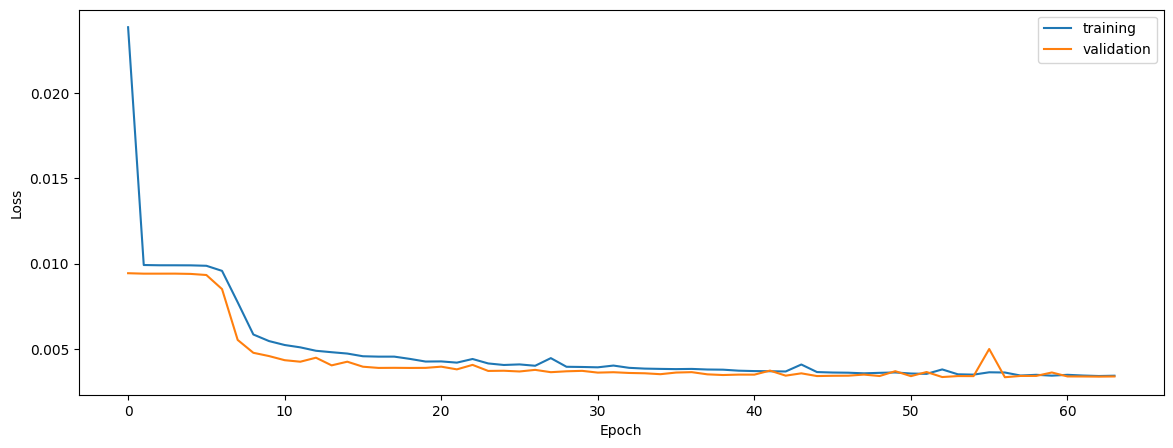

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.808171607727369
0.8031456995078866
0.7592735406916454


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.808171607727369
0.8031456995078866
0.7592735406916454


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8118183597021276
0.8051452738710615
0.7692603367581673


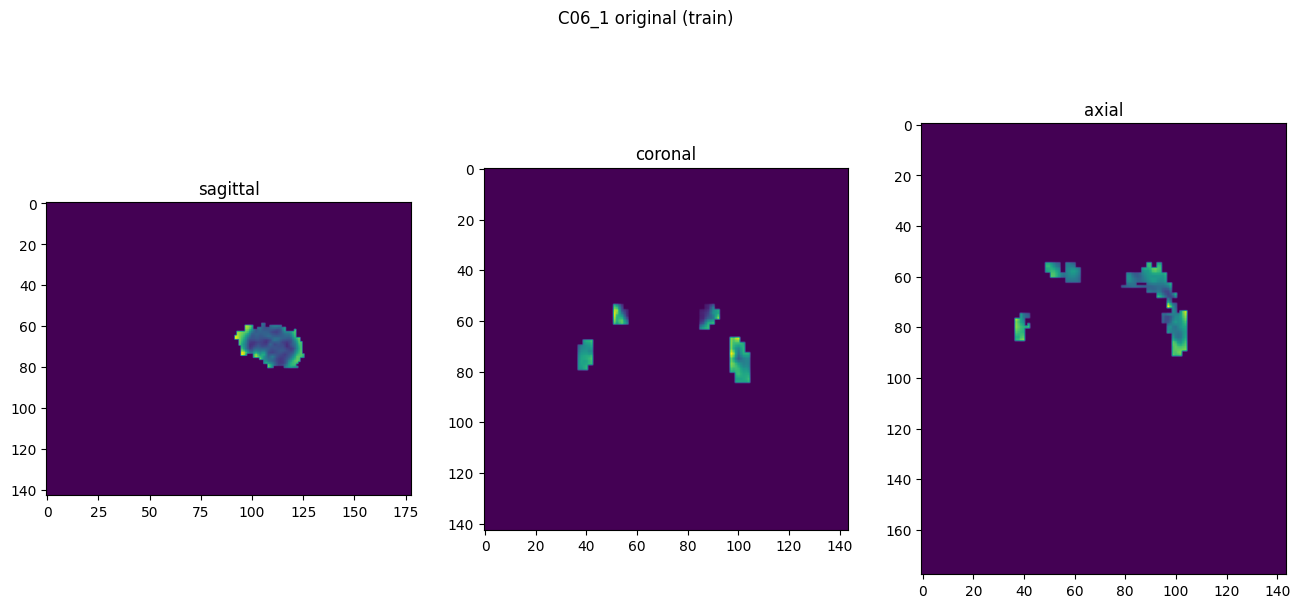

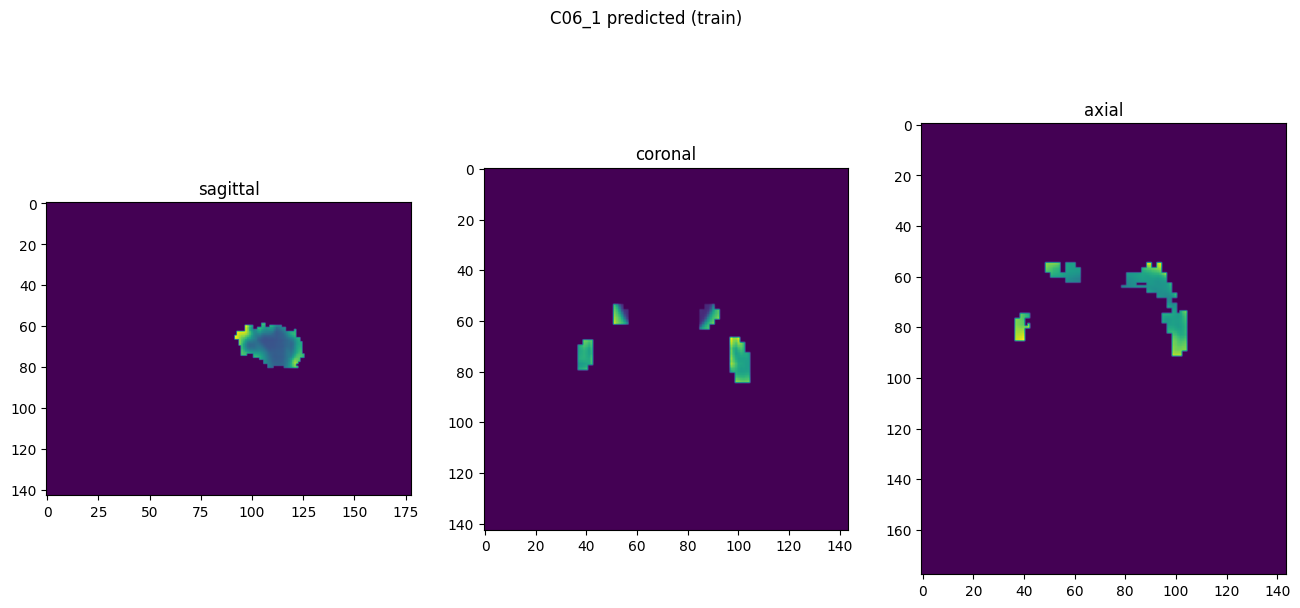

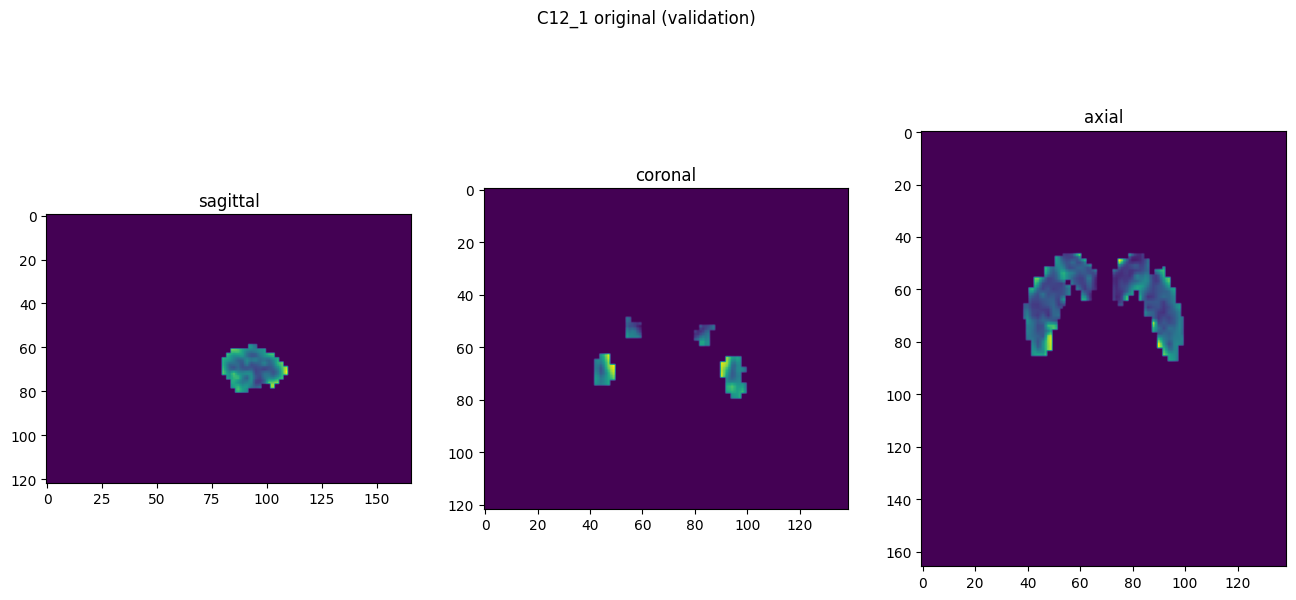

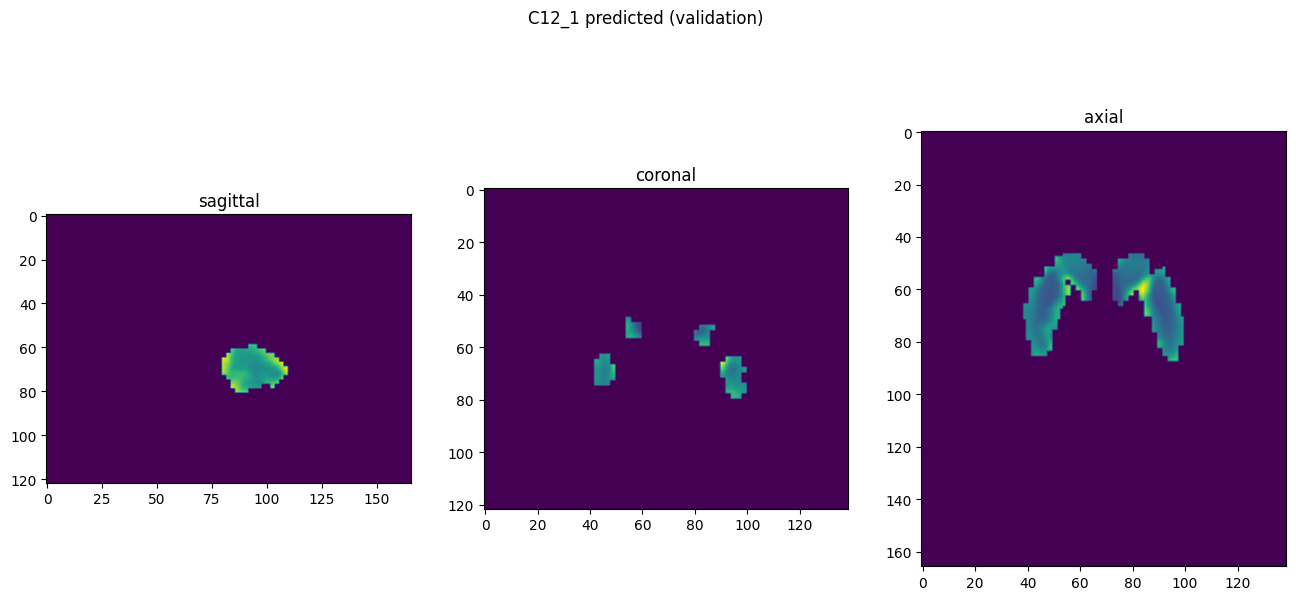

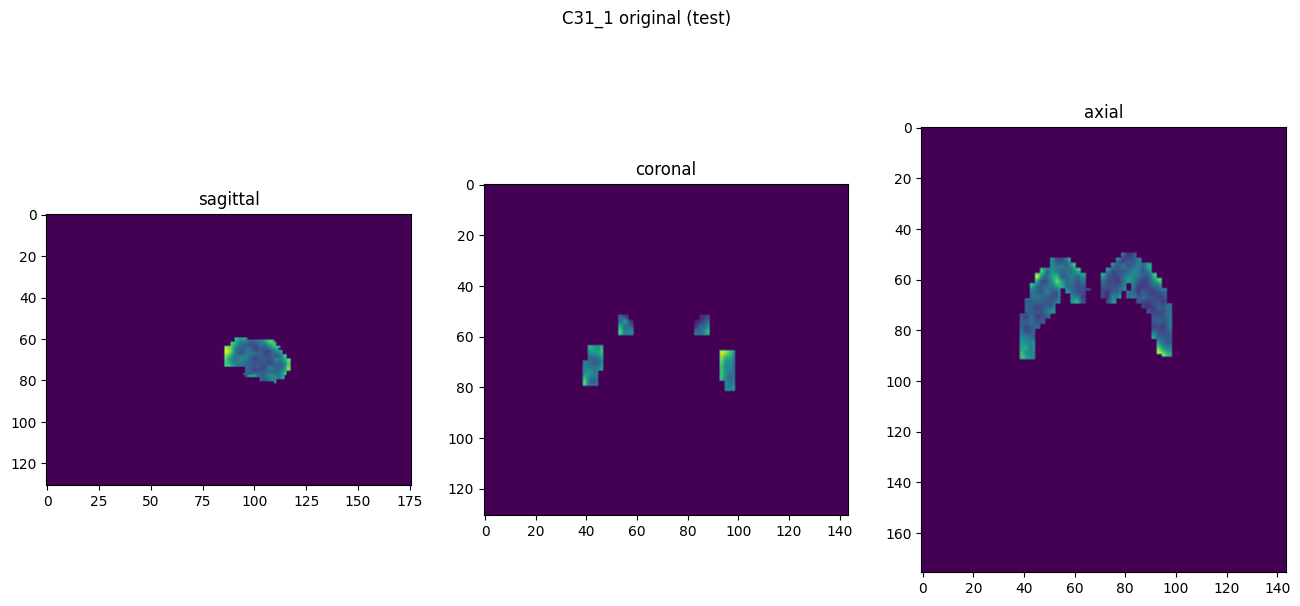

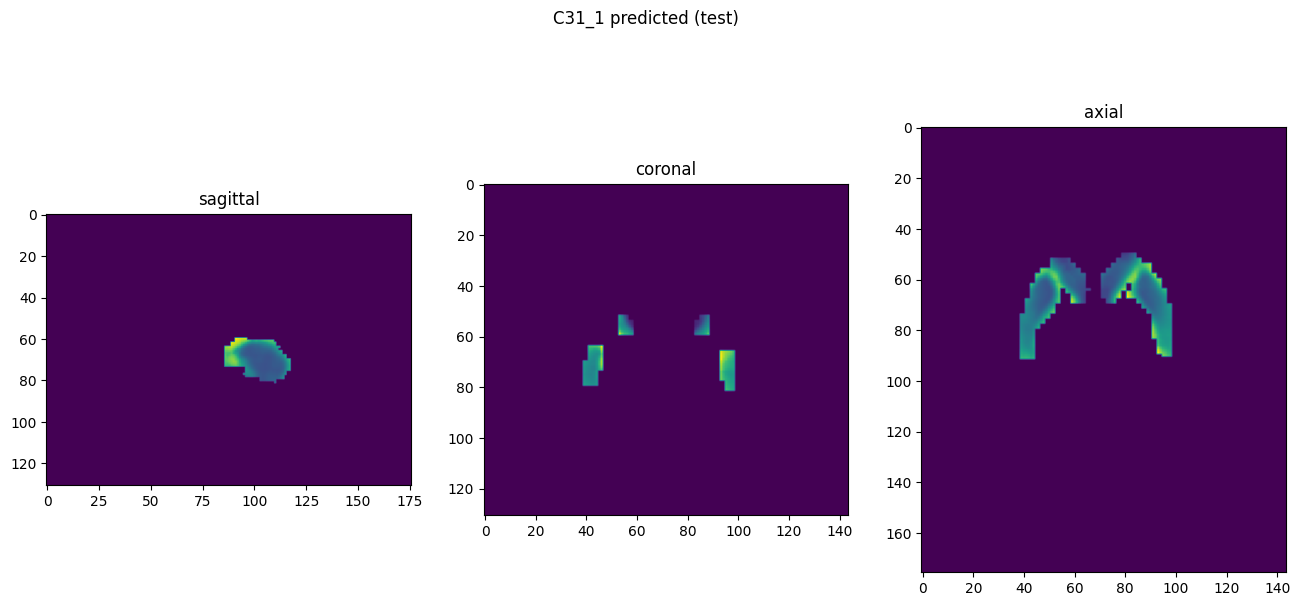

In [10]:
showResults(model, gen, threshold=None, background=False)